**Single Cell Resolution Analysis of Ca Imaging Data for Hydra v4** 
=============================================================
*(Use with data from tdTomato_GCamP Animals)*

Requires:
-------------------------
- Green and Red Channel Videos From 2-Colour Confocal (GCaMP Channel and tdTomato)
- Tracking Position Information From ICY Spot Tracking Protocol (Exported as CSV)
- Conda Environment: Caiman_NOAH3
- SCHyA .py file

INPUT PATHS
-----------------
Enter paths to the appropriate files                    
**Videos must be .avi (convert in imageJ if not)**     
**Can also use a Tif sequence folder - change the read data function to Read_Data_TIFseq for this**    
**If using windows**: Paths must start with an 'r' character: e.g. vid_path = **r**"C:\Users\rylab\ path to your file \clip.avi"

In [1]:
#input path to your .csv from ICY
csv_path = r'C:\Users\rylab\Documents\NoahT2022\Data\SingleCell_Tracking\ALI_comp\redTracks.csv'

#input path to .avi of GCaMP Video
vid_path = r'C:\Users\rylab\Documents\NoahT2022\Data\SingleCell_Tracking\ALI_comp\6X_G7_REST (2).avi'

#input path to .avi of tdTomato Video
red_vid_path = r'C:\Users\rylab\Documents\NoahT2022\Data\SingleCell_Tracking\ALI_comp\6X_tdt_REST.avi'


SET UP DATA  
-----------------------
Run the following cells to set up the 
data to be analysed        
**Set the FFmpeg path before running this cell**

In [2]:
#importing packages

import SCHyA as hy
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import numpy as np
import seaborn as sns

c:\Users\rylab\anaconda3\envs\caiman_noah3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
c:\Users\rylab\anaconda3\envs\caiman_noah3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depre

Bokeh could not be loaded. Either it is not installed or you are not running within a notebook


In [3]:
#reading in data
positions, vid, red_vid = hy.Read_Data(csv_path, vid_path, red_vid_path)

In [4]:
#reshape the .csv into a more useable form
posit = hy.reshaper(positions)

#run time = 25.5m (with prints)
#will need to reevaluate how this function runs

c:\Users\rylab\Documents\NoahT2022\CodeRepos\SingleCell_analysis\SCHyA.py:224: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  posit = np.asanyarray(position_reshaped)


In [5]:
#Get Information About Raw Data
num_frames = len(vid)
num_red_frames = len(red_vid)
num_tracks = int(positions[len(positions)-1,0])
#Display Information
print('Numer of Frames in Green Video:', num_frames)
print('Number of Frames in Red Video:', num_red_frames)
print('Number of Points Tracked by ICY:', num_tracks)

Numer of Frames in Green Video: 1000
Number of Frames in Red Video: 1000
Number of Points Tracked by ICY: 2906


CALCIUM SIGNAL EXTRACTION
------------------------
These following cells will remove neurons that were not completely tracked throughout the video, extract a region of interest around each fully tracked neuron, and extract the intensity of each neuron throughout the video and plot the raw intensities. The signal can then be corrected for motion artefacts by finding the ratiometric signal between the green and red channels - dR/R; or through the use of Independant Component Analysis. 

In [6]:
#Discard Neurons which were incompletely tracked
posit_corrected = hy.remove_incomplete_tracks(posit, num_frames)

The Following 2 Cells may Give a Runtime Warning - This is Fine

**Must Run the Extract_Fluorescence function before the SingleCellIntensities function as you need to use the updated 'posit_corrected' output from Extract_Fluorescence as SingleCellIntensities as no feature to correct this itself**

In [99]:
#Extract the fluorescence intensity in the GCaMP channel throughout the video for each neuron

#size of ROI
# dim = 9
dim=9
# subROI_Circle_size = 4
subROI_Circle_size = 4
LookBack = 4 #resistance of tracking to movement i.e. how quickly a tracked neuron can move before position resets

#Extract large ROI and remove points too close to edge
intensities_raw, posit_corrected_raw = hy.Extract_Fluorescence(posit_corrected, vid, dimention = dim)

#extract signal from subROI around neuron
intensities1, posit_corrected1, neuron_pts = hy.SingleCellIntensities(vid, posit_corrected_raw, dim, subROI_Circle_size, LookBack)

In [100]:
#Extract the fluorescence intensity in the Red channel throughout the video for each neuron

intensities_red, posit_corrected1 = hy.Extract_Fluorescence(posit_corrected1, red_vid, dim)

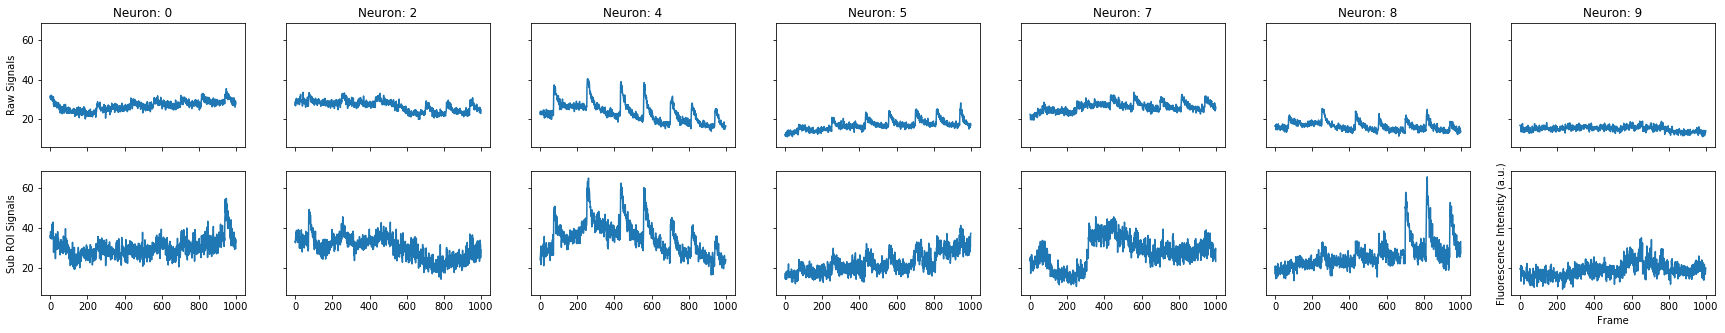

In [101]:
#Figure1 subplots 

fig, axs = plt.subplots(2, 7, sharex =True, sharey=True, figsize=(30, 5))

keyCells = [0,2,4,5,7,8,9]

axs[0,0].set_ylabel('Raw Signals')
axs[1,0].set_ylabel('Sub ROI Signals')

for i, neuron in enumerate(keyCells):
    axs[0,i].set_title('Neuron: ' + str(neuron))

    axs[0,i].plot(intensities_raw[neuron])
    axs[1,i].plot(intensities1[neuron])

plt.xlabel("Frame")
plt.ylabel("Fluorescence Intensity (a.u.)")
plt.show()

In [116]:
%%capture

#Investigating neuron 5
# (neuron, video, positions, dimentionROI, Circle_radius, distance_threshold, display_on = False):
_, _, _, display = hy.SingleCellIntensity(7,vid,posit_corrected_raw,9,4,4,True)

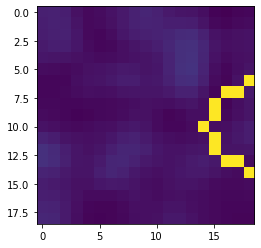

In [117]:
# change this .jpg
#this is slow because i save every image individually - work out how to save them in batches to speed this up :)
for i in range(len(display)):
    plt.imshow(display[i])
    path = r"C:\Users\rylab\Desktop\neuronTrack7\New folder"
    title = path + 'neuron_' + str(i) + '.tif'
    plt.savefig(str(title), format = 'tif')

In [104]:
# #Raw Signal Figures:

# #NOTE: Neuron 4 is a particularly good example of RP1 activity and can be used as a guid to evaluate later predictions of RP1 neurons

# """
# Neurons for Display:
# 0,2,5,7,8,9
# (9 is a nematocyte)
# """
# #without sub-ROI correction 
# for i in range(12):
#     plt.plot(intensities_raw[i])
#     plt.title('Raw Fluorescence Trace - Neuron: ' + str(i))
#     plt.xlabel('Frame')
#     plt.ylabel('Fluorescence Intensity (a.u.)')
#     plt.show()

In [105]:
#Intensities using subROI tracking method

# for i in range(12):
#     plt.plot(intensities1[i])
#     plt.title('Raw Fluorescence Trace - Neuron: ' + str(i))
#     plt.xlabel('Frame')
#     plt.ylabel('Fluorescence Intensity (a.u.)')
#     plt.show()

number of neurons =  314


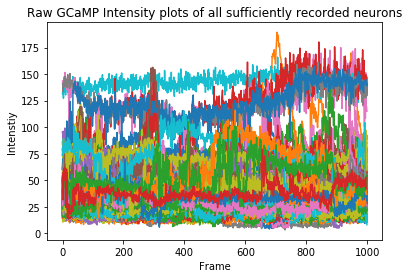

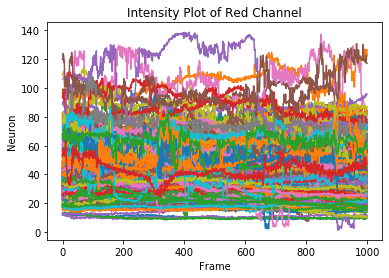

In [106]:
#plot raw neuronal intensities & display number of fully tracked neurons
number_of_neurons = len(intensities1)
print('number of neurons = ', number_of_neurons)

for track in range(len(intensities1)):
    plt.plot(intensities1[track])
    plt.title('Raw GCaMP Intensity plots of all sufficiently recorded neurons')
    plt.xlabel('Frame')
    plt.ylabel('Intenstiy')
plt.show()

#Plot intensities of red channels - used to identify motion artefacts and leaking between channels
for track in range(len(intensities1)):
    plt.plot(intensities_red[track])
    plt.title('Intensity Plot of Red Channel')
    plt.xlabel('Frame')
    plt.ylabel('Neuron')

c:\Users\rylab\anaconda3\envs\caiman_noah3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


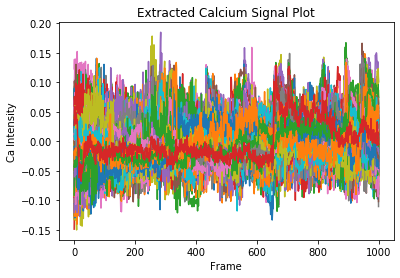

In [170]:
#DeltaR/R or ICA used to correct for motion artefacts and cross channel leaking
#Obtain Artefact Free Ca Signal
CaSignal = hy.ICAdecorr(intensities_raw, intensities_red, 0.5, 10)

#Plot Signal
for i in range(len(CaSignal)):
    plt.plot(CaSignal[i])
plt.title('Extracted Calcium Signal Plot')
plt.xlabel('Frame')
plt.ylabel('Ca Intensity')
plt.show()

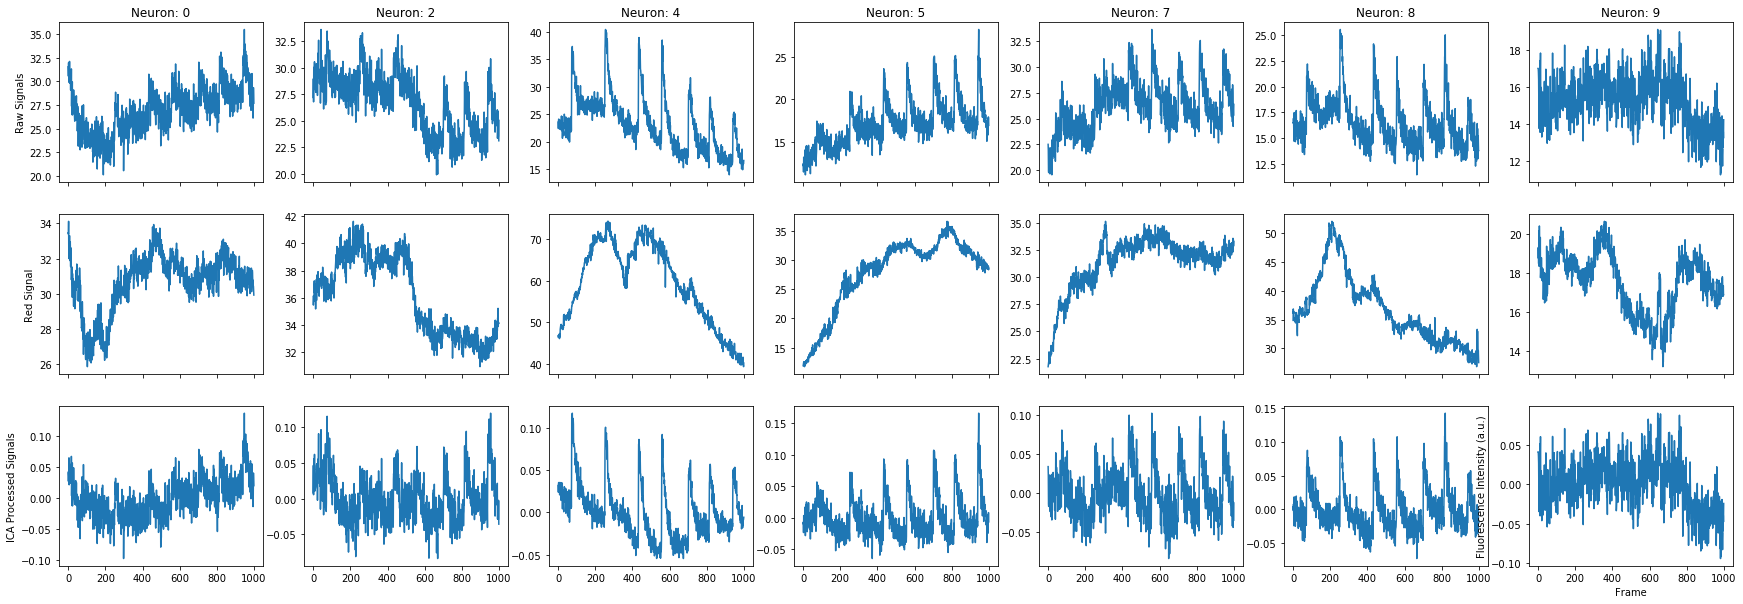

In [171]:
#pre and post ICA neurons

fig, axs = plt.subplots(3, 7, sharex =True, sharey=False, figsize=(30, 10))

keyCells = [0,2,4,5,7,8,9]

axs[0,0].set_ylabel('Raw Signals')
axs[1,0].set_ylabel('Red Signal')
axs[2,0].set_ylabel('ICA Processed Signals')

for i, neuron in enumerate(keyCells):
    axs[0,i].set_title('Neuron: ' + str(neuron))

    axs[0,i].plot(intensities_raw[neuron])
    axs[1,i].plot(intensities_red[neuron])
    axs[2,i].plot(CaSignal[neuron])

plt.xlabel("Frame")
plt.ylabel("Fluorescence Intensity (a.u.)")
plt.show()


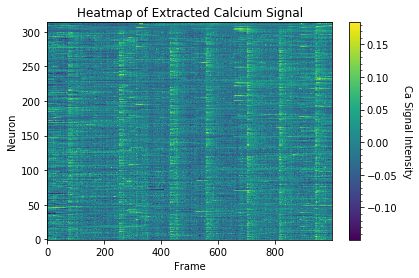

In [127]:
#Plot Heatmap of Calcium Signal
#can normalise here for better signal...
hy.plot_heatmap(CaSignal, 'Heatmap of Extracted Calcium Signal', 'Ca Signal Intensity')

Calcium Signal Extraction - Optional Cells
--------------------------
**These Cells Dont Need to be Run**          
Cells for evaluating performance or saving preliminary results        
Only Run the Cells you want to

**Optional Cells to Evaluate ROI Tracking**      
Input frame number to view all of the ROIs tracked in that frame      

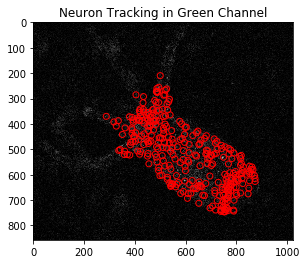

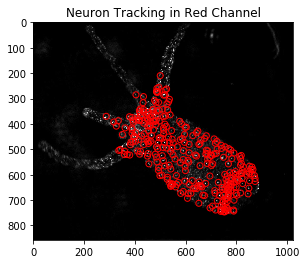

In [12]:
#superimpose ROIs on video frame in both channels

#select frame to view
frame_to_view = 510

hy.Super_impose(vid, frame_to_view, posit_corrected1, 'Neuron Tracking in Green Channel')
hy.Super_impose(red_vid, frame_to_view, posit_corrected1, 'Neuron Tracking in Red Channel')

**Optional Cells to Evaluate Effect and Correction of Motion Artifacts and Red Leakage**

In [13]:
#Plot Raw Transients in Green - uncomment to use!

# hy.plot_all(intensities1)

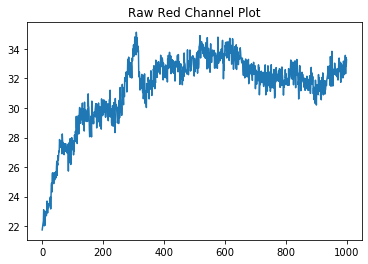

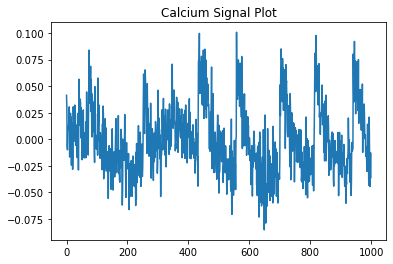

In [168]:
#Plot Red Transient to check for motion artefacts and leaking
Neuron_with_possible_artefact = 7

plt.figure(1)
plt.title('Raw Red Channel Plot')
plt.plot(intensities_red[Neuron_with_possible_artefact])
plt.show()

#After Correction:
plt.figure(2)
plt.plot(CaSignal[Neuron_with_possible_artefact])
plt.title('Calcium Signal Plot')
plt.show()

**Optional Cell to Evaluate Activity and Tracking of Individual Neurons**     
Allows comparison between intensity trace of a neuron and that neuron's ROI at a particular frame    
Input Neuron Number and Frame Number

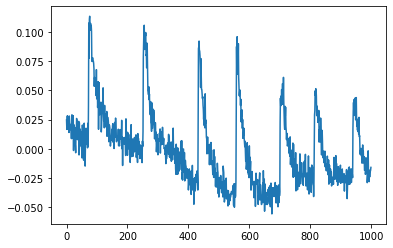

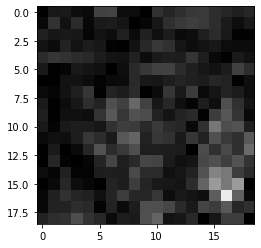

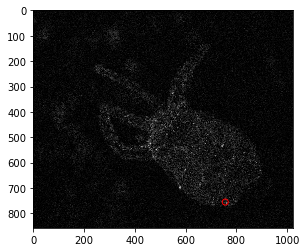

In [128]:
#input neuron to check
neuron = 4

#input frame form video to view the ROI
eval_frame = 80

hy.full_eval(neuron, CaSignal, eval_frame, dim, posit_corrected, vid)

FILTERING & SMOOTHING
-----------------------

The following cells will filter the intensity traces of the neurons to remove signal that are likely from nematocytes, smooth the results to reduce the appearance of noise, and detrend the resulting data

In [197]:
#Detrending data - use on filtered or smoothed data

#Set Polynomial Degree
poly_deg = 15

detrended = hy.detrend_all(intensities_raw, poly_deg)

In [198]:
def detrend(data, polynomial_degree):
    x_vals = np.arange(len(data))
    coeffs = np.polyfit(x_vals, data, polynomial_degree)
    polynomial = np.polyval(coeffs, x_vals)
    return polynomial

keyCells = [0,2,4,5,7,8,9]
plottingPolys = []
for cell in keyCells:
    # plt.plot(CaSignal[cell])
    # plt.show()
    signal = detrend(intensities_raw[cell], poly_deg)
    # plt.plot(signal)
    # plt.show()
    plottingPolys.append(signal)

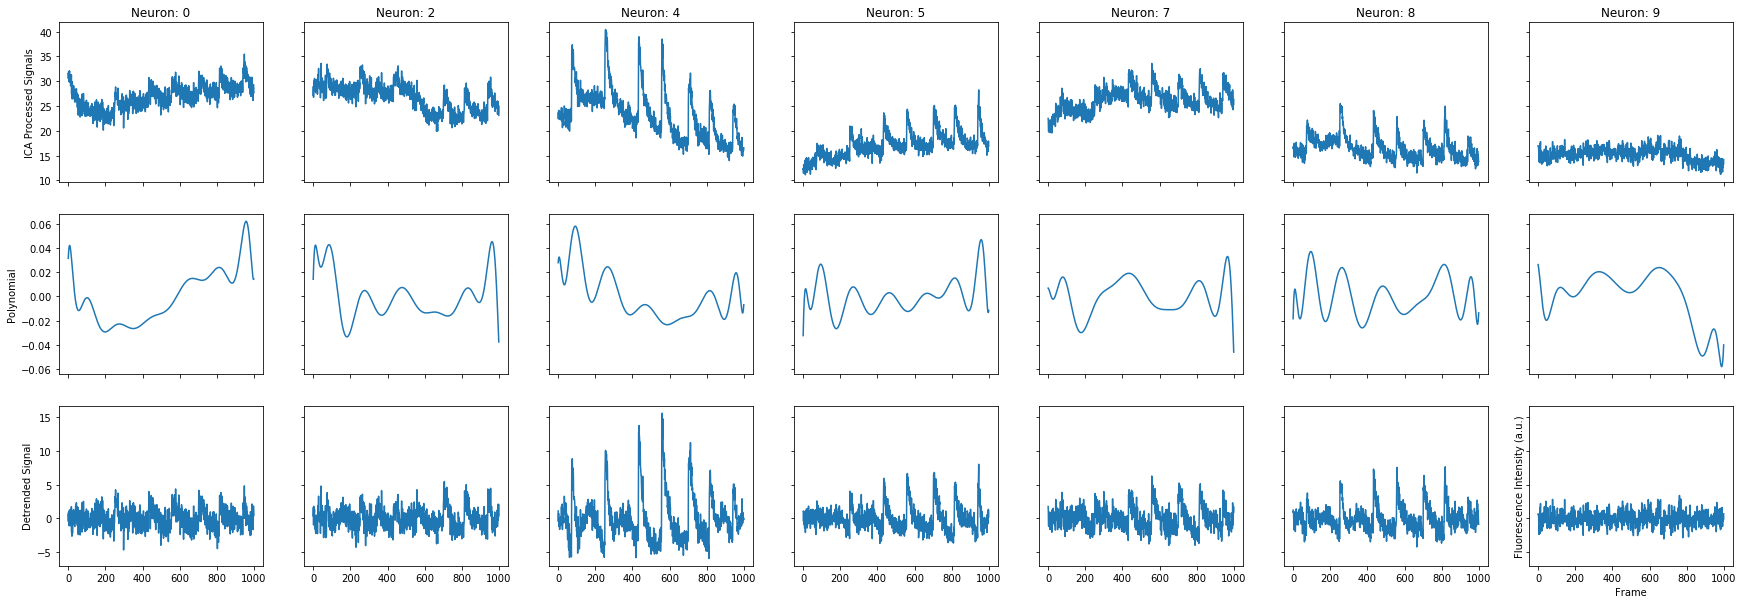

In [208]:
fig, axs = plt.subplots(3, 7, sharex = 'col', sharey='row', figsize=(30, 10))

keyCells = [0,2,4,5,7,8,9]

axs[0,0].set_ylabel('ICA Processed Signals')
axs[1,0].set_ylabel('Polynomial')
axs[2,0].set_ylabel('Detrended Signal')

for i, neuron in enumerate(keyCells):
    axs[0,i].set_title('Neuron: ' + str(neuron))

    axs[0,i].plot(intensities_raw[neuron])
    axs[1,i].plot(plottingPolys[i])
    axs[2,i].plot(detrended[neuron])

plt.xlabel("Frame")
plt.ylabel("Fluorescence Intensity (a.u.)")
plt.show()


In [206]:
#Filter Nematocytes - Filtering performed via evaluating fit with a Gaussian distribution

alpha = 1e-5 #Tune threshold for coherence to gaussian distribution - need to use detrended data with this function
detrended2, posit_corrected2, removed = hy.Gaussian_noise_filter(detrended, alpha, posit_corrected1)

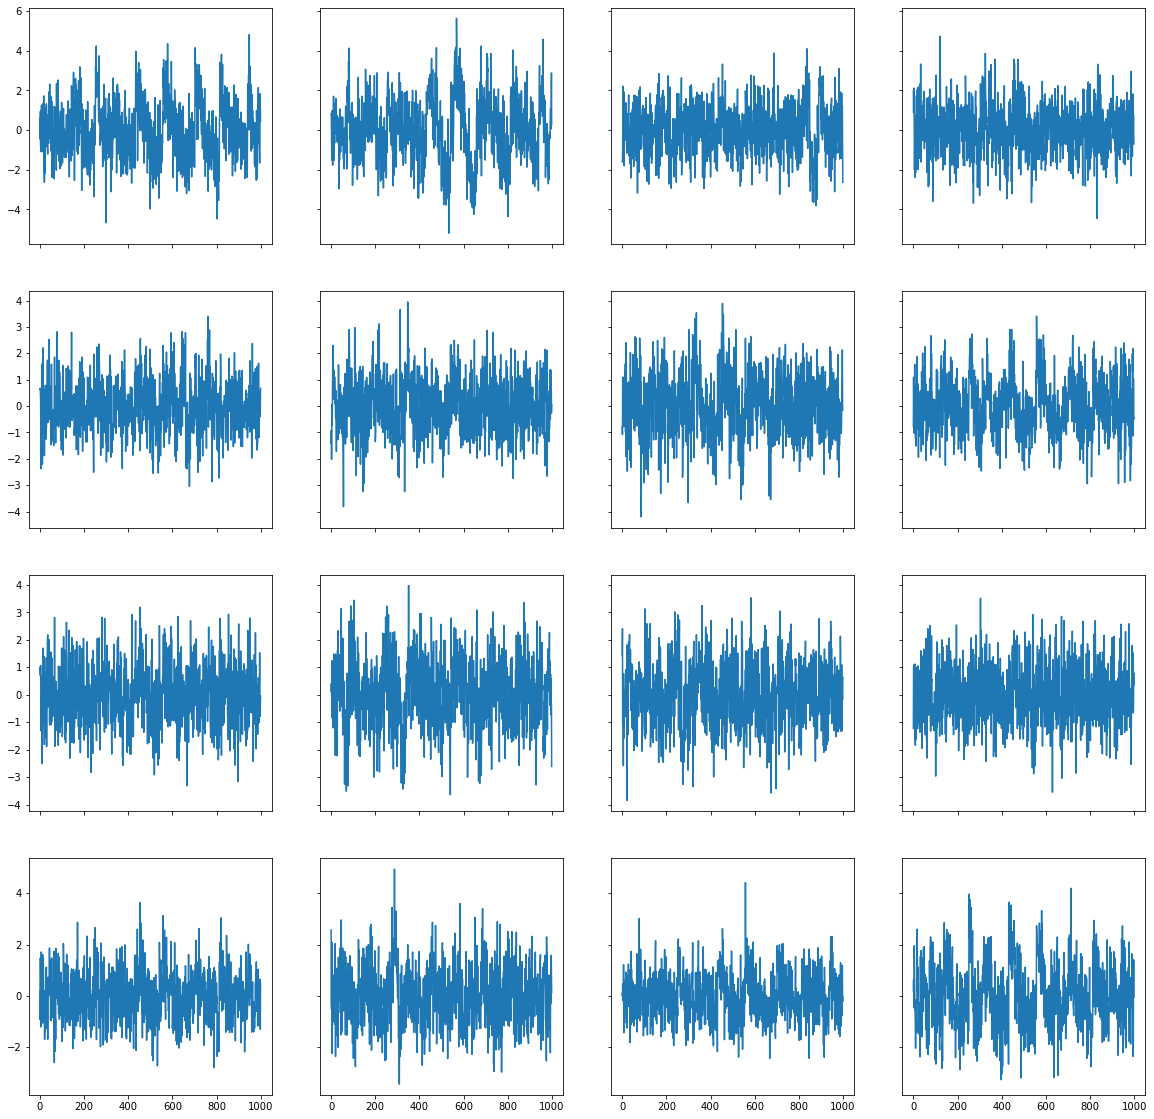

In [207]:
fig, axs = plt.subplots(4, 4, sharex = 'col', sharey='row', figsize=(20, 20))
for i, cell in enumerate(removed[0:16]):
    if i<4:
        axs[0,i].plot(cell)
    elif i >=4 and i < 8:
        axs[1,i-4].plot(cell)
    elif i >=8 and i < 12:
        axs[2,i-8].plot(cell)
    elif i >=12 and i < 16:
        axs[3,i-12].plot(cell)

plt.show()

In [18]:
#evaluate filtering of neurons

# hy.plot_all(removed)

no of neurons:  314


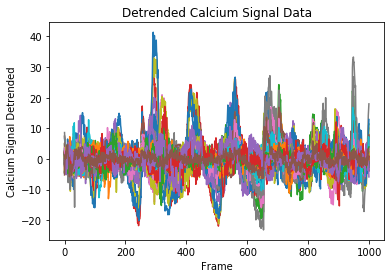

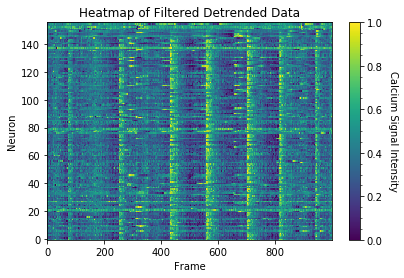

In [209]:
#Display Filtering and Smoothing Results

#Display Total Number of Neurons After Filtering
print('no of neurons: ', len(detrended))

plt.figure(3)
for i in range(len(detrended2)):
    plt.plot(detrended2[i])
plt.title('Detrended Calcium Signal Data')
plt.xlabel('Frame')
plt.ylabel('Calcium Signal Detrended')
plt.show()

hy.plot_heatmap(hy.norm_all_data(detrended2), 'Heatmap of Filtered Detrended Data', 'Calcium Signal Intensity')

In [20]:
#Plot all remaining neurons after filtering and processing - uncomment to use

# hy.plot_all(detrended2)

CALCIUM SIGNAL ANALYSIS
-------------------------------------

The following cells analyse the results to show extract spikes from the Calcium intensity data

**Tune Threshold used to Indentify Spikes to Fit Data Using Evaluation Cell for FOOPSI at End of Script**

In [218]:
#Create Raster Plot using CAIMAN's FOOPSI function - Denoising and Deconvolution

#foopsi
Foopsi_ca, spikes_signal_dR = hy.FOOPSI_all(detrended2)

#Extract Raster Plot Data

#Threshold (could use a theoretical value for threshold! - See CAIMAN Docs - but trial & error is also fine)
#USE FOOPSI EVALUATION CELL TO TUNE THIS PARAMETER (0.04 works well)
spike_thresh_dR = 0.4

raster_array_dR = hy.Find_Raster_adaptive2(spikes_signal_dR, spike_thresh_dR)

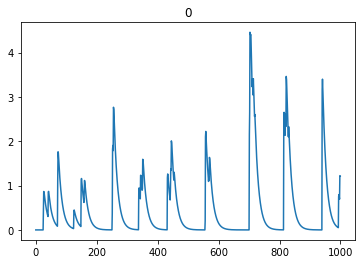

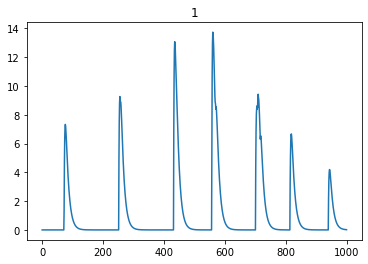

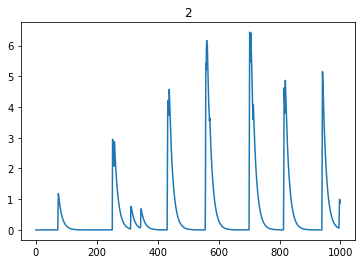

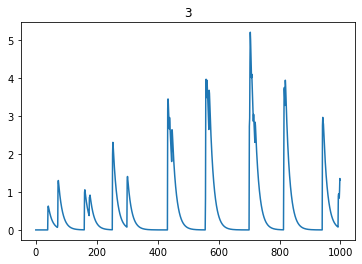

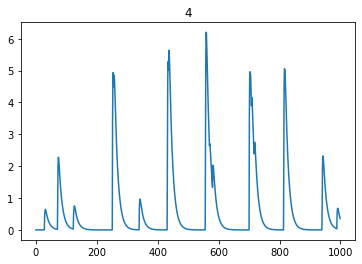

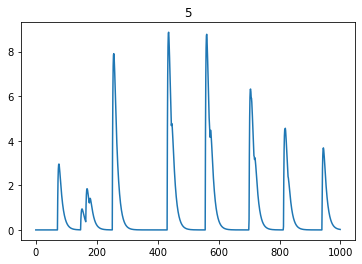

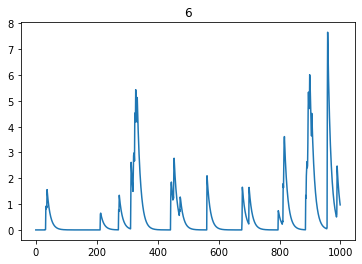

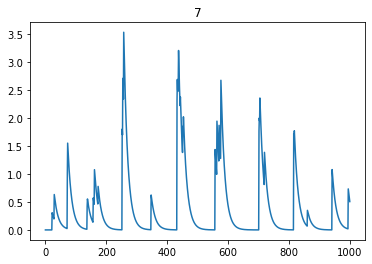

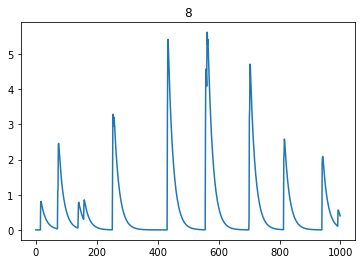

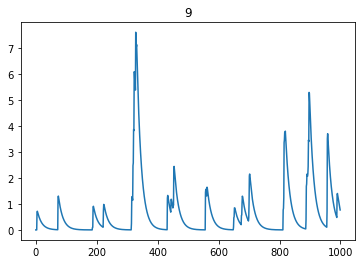

In [219]:
#Plot all denoised calcium traces - uncomment to use!

hy.plot_all(Foopsi_ca[0:10])

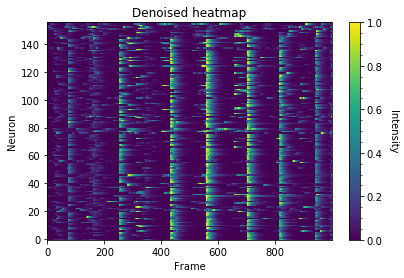

In [221]:
hy.plot_heatmap(hy.norm_all_data(Foopsi_ca), 'Denoised heatmap', 'Intensity')

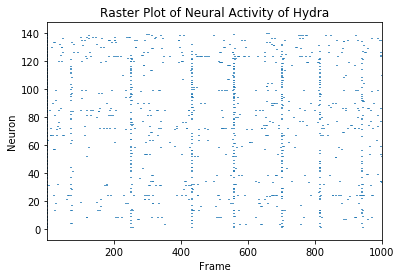

In [27]:
#Display Results

#plot raster
#zero values from way array was made array give large syncronous train at start of the signal - should fix (.append method?)
plt.figure(2)
plt.eventplot(raster_array_dR,linelengths = 0.6)
plt.ylabel('Neuron')
plt.xlabel('Frame')
plt.title('Raster Plot of Neural Activity of Hydra')
plt.xlim((1,len(raster_array_dR[0])))
plt.show()

In [25]:
#plot rasterplot for all neurons - uncomment to use!

# for i in range(len(raster_array_dR)):
#     plt.eventplot(raster_array_dR[i],linelengths = 0.6)
#     plt.xlim((1,len(raster_array_dR[0])))
#     plt.title(i)
#     plt.show()

BEHAVIOUR ANALYSIS WITH NEURAL ACTIVITY
---------------------------------------------
These cells plot neural activity and behaviour together to allow comparision between neural activity and behaviour     
Most of this step still needs to be done by hand unfortunately...

In [ ]:
# #Input Behaviour Arrays

# #behaviour array: [frame behaviour turns on,frame off,on,off,on,... etc]
# behaviour_frames = [0,212,605,len(detrended[0])]

# #fill with numbered behaviourws in order they occur
# behaviours = [1,0,1]

# #fill with colours corresponding to numbered behaviours
# colours=['blue','green']

In [ ]:
# #Display Neural Activity with Behaviour

# plt.figure(1)
# fig, ax = plt.subplots()
# ax.margins(0.02)
# for behav in range(len(behaviour_frames)-1):
#     colour_face = colours[behaviours[behav]]
#     ax.axvspan(behaviour_frames[behav],behaviour_frames[behav+1], facecolor = colour_face, alpha = 0.2)
# for i in range(len(intensities1)):
#     plt.plot(intensities1[i])
# plt.title('Raw Intensities plotted with CB and RP behaviour (CB=green)')
# plt.xlabel('Frame')
# plt.ylabel('Intensity')
# plt.show()

# plt.figure(2)
# fig, ax = plt.subplots()
# ax.margins(0.02)
# for behav in range(len(behaviour_frames)-1):
#     colour_face = colours[behaviours[behav]]
#     ax.axvspan(behaviour_frames[behav],behaviour_frames[behav+1], facecolor = colour_face, alpha = 0.2)
# for i in range(len(detrended2)):
#     plt.plot(detrended2[i])
# plt.title('Processed Intensities plotted with CB and RP behaviour (CB=green)')
# plt.xlabel('Frame')
# plt.ylabel('Calcium Signal Intensities Detrended')
# plt.show()

# plt.figure(3)
# fig, ax = plt.subplots()
# ax.margins(0.02)
# for behav in range(len(behaviour_frames)-1):
#     colour_face = colours[behaviours[behav]]
#     ax.axvspan(behaviour_frames[behav],behaviour_frames[behav+1], facecolor = colour_face,alpha = 0.2)
# plt.eventplot(raster_array_dR,linelengths = 0.6)
# plt.xlim((1,len(raster_array_dR[0])))
# plt.ylabel('Neuron')
# plt.xlabel('Frame')
# plt.title('Raster Plot of Neural Activity of Hydra Plotted with Behaviour')
# plt.show()

CORRELATION AND INTERPRETATION OF DATA
-----------------------------------
The following cells work to group neurons together into ensembles, display various froms of correlation data presentation, and correlate each neuron to different types of behaviour

**Input Correlation Threshold to be Used to Group Neurons**

In [ ]:
#Create Dendogram (can change method between ward, average, etc)
CaSignal_norm = spikes_signal_dR
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(CaSignal_norm, method='ward'))

**Input Number of Clusters Based on Results from Dendogram**

In [ ]:
#extract and view neurons from each cluster 

#number of clusters chosen from examination of dendogram
number_of_clusters = 6

clusters = hy.give_cluster_assigns(pd.DataFrame(CaSignal_norm), number_of_clusters, transpose=False)
clusters = clusters.values

#plot specific cluster's neurons traces

cluster_to_view = 4

for i in range(len(clusters)):
    if clusters[i] == cluster_to_view:
        plt.figure(i-1)
        plt.title(i)
        plt.plot(Foopsi_ca[i])
        plt.show()

In [ ]:
#Super impose locations of neurons in specified Cluster onto video frame

cluster_to_view = 1
frame_for_cluster = 300
video_for_cluster = vid
title_for_cluster = 'Cluster Positions'

hy.Super_impose_cluster(video = video_for_cluster, frame_to_view = frame_for_cluster, posit_corrected = posit_corrected, clusters = clusters, cluster_to_view = cluster_to_view, Title = title_for_cluster)

In [ ]:
#ClusterMap
#change figure size to see all labels if necessary

df = pd.DataFrame(np.transpose(CaSignal_norm))

# Draw the full plot
sns.clustermap(df.corr(), center=0, cmap="coolwarm",linewidths=.75, figsize=(19, 19), method = 'ward')

In [ ]:
#Investigate Correlations from ClusterMap

#input neurons to view
neuron_1 = 4
neuron_2 = 97

plt.figure(1)
fig, ax = plt.subplots()
# ax.margins(0.02)
# for behav in range(len(behaviour_frames)-1):
#     colour_face = colours[behaviours[behav]]
#     ax.axvspan(behaviour_frames[behav],behaviour_frames[behav+1], facecolor = colour_face,alpha = 0.2)
plt.plot(detrended2[neuron_1])
plt.plot(detrended2[neuron_2])
plt.show()

plt.figure(2)
plt.title(neuron_1)
plt.eventplot(raster_array_dR[neuron_1],linelengths = 0.6)
plt.xlim((1,len(raster_array_dR[0])))
plt.show()

plt.figure(3)
plt.title(neuron_2)
plt.eventplot(raster_array_dR[neuron_2],linelengths = 0.6)
plt.xlim((1,len(raster_array_dR[0])))
plt.show()

In [ ]:
#Single neuron investigation

neuron_to_investigate = 4
frame_to_investigate = 80

hy.single_neuron_investigation(neuron_to_investigate, intensities1, Foopsi_ca, raster_array_dR, vid, frame_to_investigate, dim, posit_corrected2)

**Save Data**
===============
**Optional Cells to Save Results**        
Run these cells to save the data as a .csv         
Input file name and path where file should be saved           
**On Windows: Paths still need to start with 'r'**              
e.g. r'C:\Users\rylab\Documents\path to your folder\title.csv'

**Save Raw GCamp Intensity Data**

In [ ]:
#Save Raw GCamp Intensity data as a .csv 

# Save_Path = r'C:\Users\rylab\Documents\Noah2019_desktop\Columbia_Project\hydra_Vids\2-colour\single_cell_intensity_behaviour_longclip.csv'

# intensity_dataframe = pd.DataFrame(intensities)
# intensity_dataframe.to_csv(Save_Path)

**Save CaSignal Intensity Data**

In [ ]:
#save CaSignal data to .csv

# Ca_save_path = r'C:\Users\rylab\Documents\Noah2019_desktop\Columbia_Project\hydra_Vids\2-colour\single_cell_CaSig.csv'

# intensity_dataframe = pd.DataFrame(CaSignal)
# intensity_dataframe.to_csv(Ca_save_path)

**Sava Detrended Intensity Data**

In [ ]:
#save detrended data to .csv

# dR_detrend_save_path = r'C:\Users\rylab\Documents\Noah2019_desktop\Columbia_Project\hydra_Vids\2-colour\single_cell_detrend.csv'

# dfintensity_dataframe = pd.DataFrame(detrended)
# dfintensity_dataframe.to_csv(dR_detrend_save_path)

**Save Foopsi De-noised Data**

In [ ]:
# #save Foopsi de-noised data to .csv

# Ca_denoised_path = r'C:\Users\rylab\Documents\Noah2019_desktop\Columbia_Project\Project_Behaviour_and_Neural_Activity\Single_Cell_Analysis_Neural\Single_Cell_Data\VID1_oct_4_3hz\Results\denoised_neuraldata.csv'

# ca_dataframe = pd.DataFrame(Foopsi_ca)
# ca_dataframe.to_csv(Ca_denoised_path)

**Save Raster Plot Data**

In [ ]:
#save raster data to .csv (needs to be reformatted from event plot form first)

# raster_save_path = r'C:\Users\rylab\Documents\Noah2019_desktop\Columbia_Project\hydra_Vids\2-colour\single_cell_rasterb1.csv'

# raster_array_pred = np.zeros((len(raster_array_dR),len(raster_array_dR[1])))
# for i in range(len(spikes_signal_dR)):
#     for j in range(len(spikes_signal_dR[i])):
#         if max(spikes_signal_dR[i]) > 0:
#             if spikes_signal_dR[i][j] >= spike_thresh_dR: #*np.mean(spikes_signal_dR[i]):
#                 raster_array_pred[i][j] = 1

# raster_dataframe = pd.DataFrame(raster_array_pred)
# raster_dataframe.to_csv(raster_save_path)

**Save Behaviour Data**

In [ ]:
#Save Behaviour Array tp .csv
# behaviour_Save_Path = r"C:\Users\rylab\Downloads\behav_array.csv"

# behav_array = np.zeros(len(vid))
# for i in range(len(behaviours)):
#     behav_array[behaviour_frames[i]:behaviour_frames[i+1]] = behaviours[i]
    
# behaviour_dataframe = pd.DataFrame(behav_array)
# behaviour_dataframe.to_csv(behaviour_Save_Path)

**Evaluation Cells**
====================
These cells allow for the evaluation of the tuning of various functions

**Evaluate Polynomial Detrending Parameters** 

In [ ]:
#evaluate ploynomail detrending
neuron_test_detrend = 4
#polynomial degree of 15-17 gives good results - but tune for new data!
polynomial_test_degree  = 17
detrend_one = hy.detrend(CaSignal[neuron_test_detrend],polynomial_test_degree)

x_vals = np.arange(len(CaSignal[neuron_test_detrend]))
coeffs = np.polyfit(x_vals, CaSignal[neuron_test_detrend], polynomial_test_degree)
polynomial = np.polyval(coeffs, x_vals)

plt.figure(1)
plt.plot(detrend_one)
plt.xlabel('Frame')
plt.ylabel('Detrended Intensity')
plt.title('Detrended Neural Signal')
plt.show()
plt.plot(CaSignal[neuron_test_detrend], c = 'r')
plt.plot(polynomial, c = 'b')
plt.xlabel('Frame')
plt.ylabel('Ca Signal Intensity')
plt.title('Neural Signal with Fitted Polynomial for Detrending')
plt.legend(['Motion Corrected Neural Signal', 'Fitted Polynomial'])
plt.show()

**Evaluste ICA vs Ratiometric Artefact Removal**

In [ ]:
# New ICA vs Ratiometric

ica_test_neuron = 4

a, b = np.asanyarray(hy.norm_Data(intensities1[ica_test_neuron])), np.asanyarray(hy.norm_Data(intensities_red[ica_test_neuron]))
plt.plot(a, c = 'g')
plt.title('Raw Intensities of GCaMP7 (Green) Channel')
plt.xlabel('Frames')
plt.ylabel('Normalised Intensity')
plt.show()
plt.plot(b, c = 'r')
plt.title('Raw Intensities of tdTomato (Red) Channel')
plt.xlabel('Frames')
plt.ylabel('Normalised Intensity')
plt.show()

c = (a+1)/(b+1)
plt.plot(c)
plt.title('Ratiometric Correction of Motion Artefacts')
plt.xlabel('Frames')
plt.ylabel('Intensity Ratio')
plt.show()

print(min(a))
print(min(b))

ica_g = hy.ICAdecorr([a],[b],0.05, 10)
plt.plot(ica_g[0])
plt.title('ICA Correction of Motion Artefacts')
plt.xlabel('Frames')
plt.ylabel('Normalised Intensity')
# plt.show()
# plot_all(p)
# print(c)

**Evaluate FOOPSI Parameters**

In [ ]:
#Tuning for FOOPSI 

tuning_thresh_foopsi = 0.03

evaluation_neuron_foopsi = 4
spikes_signal_tuning = hy.FOOPSI_all(hy.normalize(detrended))

plt.figure(1)
plt.plot(detrended[evaluation_neuron_foopsi])
plt.title('detrended signal for Specified Neuron')
plt.ylabel('Calcium Signal Detrended Intensity')
plt.xlabel('Frame Number')
plt.show()

plt.figure(2)
plt.plot(spikes_signal_dR[evaluation_neuron_foopsi])
plt.title('FOOPSI Results for Specified Neuron')
plt.ylabel('Estimated Neural Activity')
plt.xlabel('Frame Number')
plt.show()

**Evaluate Raster Reshaping**

In [ ]:
# #Evaluate Raster Reshaping step for saving as csv

# raster_reshape_test_neuron = 5

# plt.plot(raster_array_pred[raster_reshape_test_neuron], color = 'r')
# plt.eventplot(raster_array_dR[raster_reshape_test_neuron])

**Evaluate Neuron Tracking**

In [ ]:
# n = 4
# _,_,_,display = hy.SingleCellIntensity(neuron = n, video = vid, positions = posit_corrected, dimentionROI = dim, Circle_radius = 4, distance_threshold = 4, display_on = True)


**Save Tracked Neurons**

In [ ]:
# for i in range(len(display)):
#     plt.imshow(display[i])
#     title = 'neuron_' + str(i) + '.tif'
#     plt.savefig(str(title), format = 'tif')